# **Projeto 4 introdução a redes neurais - Redes Recorrentes**

-------------------------------------------------------------------------------------------------------------

## Objetivo: 

Classificar séries temporais, onde o modelo recebe uma janela de dados e identifica sua categoria com base nos padrões observados. O objetivo escolhido para o projeto será classificar um segmento de ECG em normal, arritmia, etc...

## Dataset

O **MIT-BIH Arrhythmia** é um dataset de série temporal contendo gravações de ECG de pacientes com diferentes tipos de arritmias. A tarefa é classificar os batimentos cardíacos com base nos sinais ao longo do tempo. Cada amostra consiste em segmentos de ECG rotulados, representando diferentes classes de batimentos. A ordem dos registros é essencial, pois os dados são sequenciais. O objetivo é identificar e classificar corretamente os tipos de batimentos cardíacos a partir dos sinais de ECG.

## Importação das bibliotecas necessárias

In [ ]:
import wfdb
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

## Preparação dos dados

#### 1. Carregamento do Dataset  
- O arquivo **ECG (mit-bih-arrhythmia-database-1.0.0)** foi carregado a partir do diretório do projeto utilizando a função `wfdb.rdrecord()` da biblioteca `wfdb`.  
- O dataset contém **sinais de ECG** com informações de **tempo e rótulos de classes** que indicam tipos de arritmia ou a ausência delas.

#### 2. Separação dos Conjuntos  
- Os dados foram divididos em **treinamento (80%)** e **teste (20%)** utilizando a função `train_test_split()` do Scikit-learn.  
- Distribuição final dos dados:  
  - **Treino:** 8.000 amostras  
  - **Teste:** 2.000 amostras  

#### 3. Normalização e Formatação dos Dados  
- Os sinais de ECG foram convertidos para **float32** e normalizados, garantindo que os valores numéricos estivessem no formato adequado para o treinamento do modelo.  
- A variável alvo (tipo de arritmia) foi convertida para **representação categórica** (classes conforme o sinal de ECG).  
- Os dados de entrada foram remodelados para o formato adequado ao modelo **LSTM**, com uma **dimensão adicional** para representar as séries temporais.

#### 4. Visualização dos Dados  
- Foram exibidos **5 exemplos do conjunto de treino** com seus respectivos rótulos (tipos de arritmia ou ausência), permitindo uma verificação visual dos padrões nas séries temporais de ECG antes do treinamento.


Tamanho do treino: (2232, 100, 1), (2232, 6)
Tamanho do teste: (559, 100, 1), (559, 6)


Text(0.5, 0.98, 'Exemplos do MIT-BIH Arrhythmia')

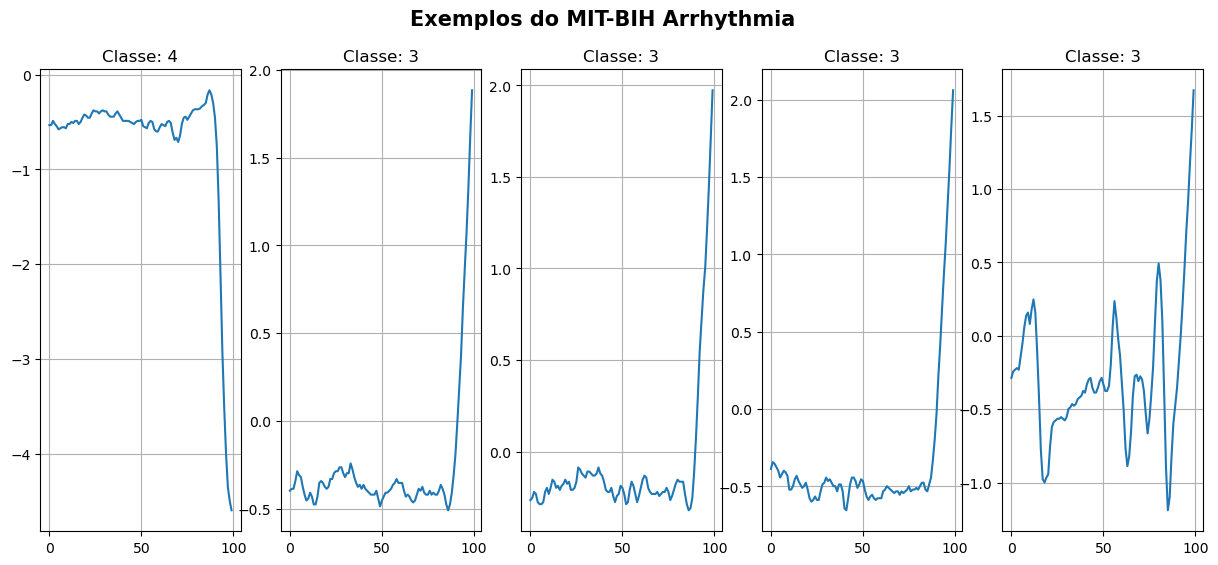

In [2]:
# Definir o caminho da pasta do dataset
caminho_dados = "./mit-bih-arrhythmia-database-1.0.0"

# Listar arquivos 
ecg = [f.split(".")[0] for f in os.listdir(caminho_dados) if f.endswith(".dat")]

# Definir uma amostra de registros para processamento
ecg_escolhido = ecg[0]  # Usaremos o primeiro como exemplo

# Carregar os sinais e anotações
sinais = wfdb.rdrecord(os.path.join(caminho_dados, ecg_escolhido))
anotacoes = wfdb.rdann(os.path.join(caminho_dados, ecg_escolhido), "atr")

# Extrair sinais e rótulos
sinais = sinais.p_signal  # Sinais de ECG (duas derivações)
rotulos = anotacoes.sample  # Posições dos batimentos
classes = anotacoes.symbol  # Tipos de batimentos

# Normalizar os sinais para intervalo [-1, 1]
sinais = (sinais - np.mean(sinais)) / np.std(sinais)

# Criar janelas de entrada para o modelo
janela = 100  # Tamanho da janela 
X, y = [], []
for i in range(len(rotulos)):
    if rotulos[i] >= janela:
        X.append(sinais[rotulos[i] - janela: rotulos[i], 0])  
        y.append(classes[i])

X = np.array(X)
y = np.array(y)

# Converter rótulos para valores numéricos
classes_unicas = sorted(set(y))
mapeamento_classes = {classe: i for i, classe in enumerate(classes_unicas)}

# Aplicar a transformação nos rótulos
y_numerico = np.array([mapeamento_classes[i] for i in y])

# Converter rótulos para formato categórico (one-hot encoding)
y_categorico = to_categorical(y_numerico, num_classes=len(classes_unicas))

# Separar treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y_categorico, test_size=0.2, random_state=42)

# Ajustar formato da entrada para o modelo LSTM (adicionar dimensão extra)
X_treino = np.expand_dims(X_treino, axis=-1)
X_teste = np.expand_dims(X_teste, axis=-1)

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do treino: {X_treino.shape}, {y_treino.shape}")
print(f"Tamanho do teste: {X_teste.shape}, {y_teste.shape}")

# Visualizar algumas amostras
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X_treino[i])
    plt.title(f"Classe: {np.argmax(y_treino[i])}")  # Exibir a classe original
    plt.grid()
plt.suptitle("Exemplos do MIT-BIH Arrhythmia", fontsize=15, fontweight='bold')

## Redes Recorrentes

### Definição
- A informação pode atingir um neurônio mais de uma vez.
- Característica principal: **memória** e **ordem temporal**.

### Funcionamento
- O novo estado da rede depende tanto da entrada quanto do estado atual, ou seja, da memória associada ao estado interno (oculto) do modelo.
- As RNNs podem recordar características importantes dos sinais anteriores.

### Rede Recorrente Padrão
- A saída $h_t$ depende da entrada $x_t$ e do próprio estado anterior da rede:
$$
A_t = f_0(A_{t-1}, x_t)
$$
$$
h_t = g_0(A_t)
$$
- Além da dependência espacial (fluxo camada a camada), as RNNs possuem dependência temporal do sinal.

### Retropropagação
- Para calcular o gradiente de um neurônio, é necessário conhecer:
  - Os gradientes dos neurônios da camada posterior (dependência espacial, por exemplo, do neurônio de saída $y$).
  - Os gradientes dos neurônios da própria camada no instante posterior (dependência temporal).
- As equações envolvidas são:
$$
\alpha^t = \phi(w_x x^t + w_a a^{t-1})
$$
$$
y^t = \phi(w_y a^t)
$$
$$
\delta_j = f'(v_j) \sum_k \delta_k w_{kj}
$$
- O processo de atualização é idêntico ao utilizado na retropropagação tradicional aplicada em redes MLP.
- Basicamente, o algoritmo é o mesmo, mudando apenas a forma de considerar as dependências.

### Problemas com o Gradiente
- **Explosão do gradiente**: Dependendo da função de ativação, o valor do gradiente pode se tornar muito elevado, saturando (estourando) as sinapses. Uma abordagem simples é estabelecer um corte, fixando o valor máximo do gradiente.
- **Desaparecimento do gradiente (vanishing)**: O gradiente pode se tornar ínfimo, impossibilitando o ajuste adequado dos pesos.
- Redes recorrentes padrão (como as unidades MCP e suas variações) podem sofrer desses problemas.

### Long Short-Term Memory (LSTM)
- Uma célula LSTM é composta por três gates: de entrada, de saída e de esquecimento (forget).
- A célula LSTM possui dois sinais de memória:
$$
c_t \quad \text{(memória de longo prazo, sinal interno)}
$$
$$
a_t \quad \text{(memória de curto prazo, sinal externo)}
$$
- Os gates são:
  - **Gate de entrada (ou de atualização):** $U$
  - **Gate de saída:** $O$
  - **Gate de esquecimento:** $F$
- A célula é capaz de recordar sinais arbitrários do passado a partir da configuração dos gates, que controlam o fluxo de informação.
- Teoricamente, sinais podem ser mantidos por longos períodos.


## Implementação

A biblioteca utilizada para implementar a LSTM (Long Short-Term Memory) neste projeto será o `TensorFlow (https://www.tensorflow.org)`, um framework amplamente utilizado para aprendizado profundo.

### Classe LSTM

Para facilitar a customização do modelo, uma classe foi criada para implementar redes LSTM. Ela permite configurar o número de camadas, o número de neurônios em cada camada e a taxa de dropout por meio de parâmetros personalizáveis. A classe constrói o modelo LSTM de forma flexível, definindo se cada camada deve retornar sequências para alimentar a próxima, e finaliza com uma camada densa com ativação softmax para a classificação. 

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

class Modelo_LSTM:
    def __init__(self, formato_entrada, num_classes, unidades_lstm=[32], dropout=0.0):
        """
        Classe para criar um modelo LSTM flexível para classificação.

        Parâmetros:
        - formato_entrada: tupla com a forma da entrada (timesteps, características)
        - num_classes: número de classes na saída do modelo
        - unidades_lstm: lista definindo a quantidade de neurônios em cada camada LSTM
        - dropout: taxa de dropout aplicada após cada camada LSTM (0.0 significa sem dropout)
        """
        self.formato_entrada = formato_entrada
        self.num_classes = num_classes
        self.unidades_lstm = unidades_lstm
        self.dropout = dropout

    def construir_modelo(self):
        """
        Método para construir e compilar o modelo LSTM.
        
        Retorna:
        - Um modelo compilado pronto para treinamento.
        """
        modelo = Sequential()

        # Primeira camada LSTM com a entrada definida
        modelo.add(LSTM(self.unidades_lstm[0], return_sequences=(len(self.unidades_lstm) > 1), input_shape=self.formato_entrada))
        if self.dropout > 0:
            modelo.add(Dropout(self.dropout))

        # Adicionando camadas LSTM intermediárias, se houver mais de uma
        for i in range(1, len(self.unidades_lstm)):
            return_seq = (i < len(self.unidades_lstm) - 1)  # Somente as intermediárias retornam sequências
            modelo.add(LSTM(self.unidades_lstm[i], return_sequences=return_seq))
            if self.dropout > 0:
                modelo.add(Dropout(self.dropout))

        # Camada de saída com ativação softmax para classificação
        modelo.add(Dense(self.num_classes, activation='softmax'))

        # Compilação do modelo
        modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        return modelo

### Primeiro Modelo

O primeiro modelo LSTM foi configurado para processar sequências de sinais de ECG com 100 timesteps e aprender padrões temporais associados às diferentes classes de arritmias. A arquitetura inclui três camadas LSTM com 64, 32 e 16 neurônios, respectivamente, todas utilizando a ativação tanh.

Para evitar overfitting e melhorar a generalização, cada camada LSTM é seguida por uma camada Dropout com taxa de 20%. A última camada é totalmente conectada (Dense) com ativação softmax, responsável por classificar os sinais em suas respectivas categorias.

O modelo será treinado por 20 épocas utilizando o otimizador Adam e a função de perda categorical_crossentropy. 

In [ ]:
# Definir o formato da entrada (tamanho da janela, 1 característica por amostra)
formato_entrada = (100, 1)  # 100 timesteps e 1 característica (sinal ECG)

# Definir o número de classes para classificação
num_classes = len(np.unique(np.argmax(y_treino, axis=1)))

# Criar a instância do modelo LSTM com 3 camadas (64, 32 e 16 neurônios)
modelo_lstm = Modelo_LSTM(formato_entrada=formato_entrada, num_classes=num_classes, unidades_lstm=[64, 32, 16], dropout=0.2)

# Construir o modelo
primeiro_lstm = modelo_lstm.construir_modelo()

### Visualização do primeiro modelo

O TensorFlow permite visualizar a arquitetura do modelo LSTM utilizando a função `plot_model`. Isso facilita a compreensão da estrutura da rede, mostrando como as camadas LSTM processam as sequências de entrada e como a camada totalmente conectada realiza a classificação. Com o parâmetro `show_shapes=True`, é possível verificar os tamanhos dos tensores em cada camada, garantindo que as dimensões estejam corretas, o que é essencial para o bom funcionamento do modelo durante o treinamento.

(-0.5, 1399.5, 2255.5, -0.5)

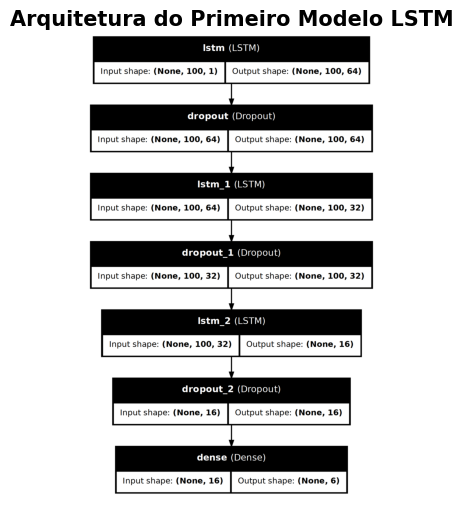

In [5]:
from keras.utils import plot_model

# Gera o diagrams do modelo
plot_model(primeiro_lstm, to_file="./imgs/primeiro_lstm.png", show_shapes=True, show_layer_names=True)

img_primeiro_lstm = plt.imread("./imgs/primeiro_lstm.png")

# Plotar a arquitetura do modelo
plt.figure(figsize=(10, 6))
plt.imshow(img_primeiro_lstm)
plt.title("Arquitetura do Primeiro Modelo LSTM", fontsize=15, fontweight='bold')
plt.axis("off")

### Treinamento do primeiro modelo

In [6]:
# Treinar o primeiro modelo
primeiro_historico = primeiro_lstm.fit(X_treino, y_treino, 
                              epochs=20, batch_size=32, 
                              validation_data=(X_teste, y_teste))

Epoch 1/20


2025-02-05 12:21:13.889918: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5296 - loss: 1.3256 - val_accuracy: 0.8766 - val_loss: 0.5940
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8856 - loss: 0.5403 - val_accuracy: 0.9338 - val_loss: 0.3564
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9230 - loss: 0.3759 - val_accuracy: 0.9302 - val_loss: 0.2837
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9295 - loss: 0.3030 - val_accuracy: 0.9463 - val_loss: 0.2303
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9391 - loss: 0.2812 - val_accuracy: 0.9445 - val_loss: 0.2200
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9426 - loss: 0.2443 - val_accuracy: 0.9463 - val_loss: 0.2104
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9489 - loss: 0.2137 - val_accuracy: 0.9481 - val_loss: 0.1984
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9476 - loss: 0.2132 - val_accuracy: 0.9535 - val_loss: 0.

### Acurácia no conjunto de teste do primeiro modelo

In [7]:
# Avaliar no conjunto de teste
perda, acuracia = primeiro_lstm.evaluate(X_teste, y_teste)
print(f"\n Acurácia no conjunto de teste: {acuracia * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9623 - loss: 0.1316

 Acurácia no conjunto de teste: 96.06%


### Histórico de perda durante o treinamento do primeiro modelo

A perda durante o treinamento e validação do modelo mede o quão bem as previsões se ajustam aos dados reais, sendo calculada pela função de custo definida na compilação. No caso deste modelo LSTM, a perda utilizada é a *categorical crossentropy*, que mede a discrepância entre as distribuições de probabilidade predita e real. Essa função é comumente usada em problemas de classificação multiclasse e é definida pela equação:  

$$
H(p, q) = - \sum_{i=1}^{n} p_i \log q_i
$$  

onde $p_i$ é a distribuição real das classes e $q_i$ é a distribuição predita pelo modelo.  

Durante o treinamento, espera-se que essa perda diminua, indicando que o modelo está aprendendo a classificar corretamente os padrões do ECG. Além disso, a métrica de acurácia acompanha o percentual de acertos. Se a perda de validação permanecer próxima à de treinamento, significa que o modelo generaliza bem sem overfitting.  

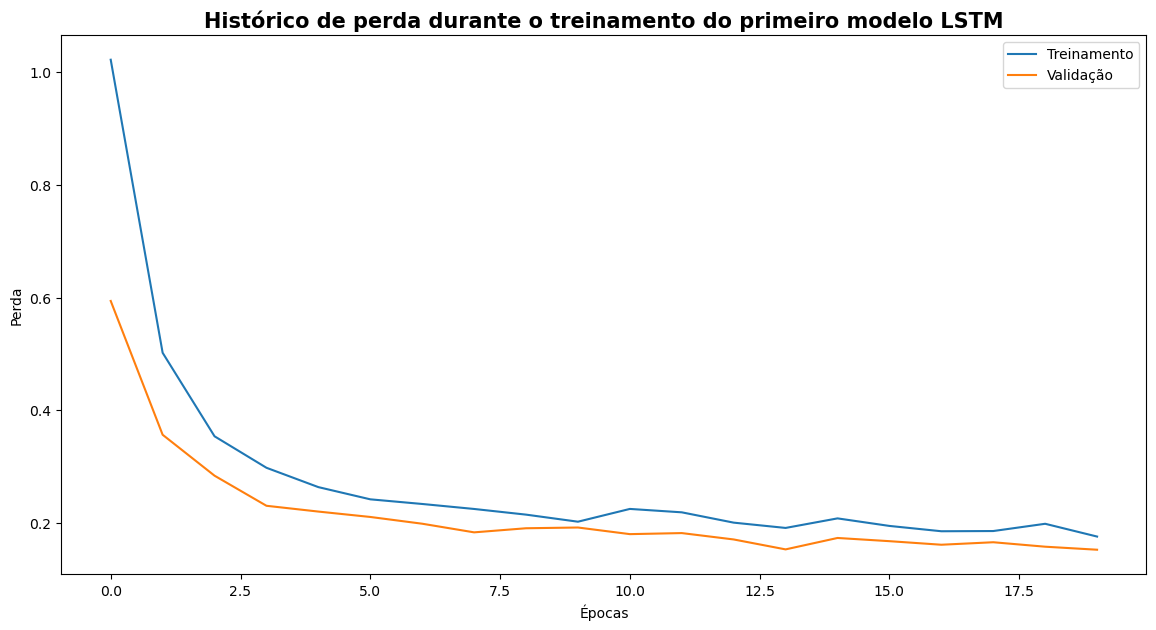

In [8]:
# Plotando o histórico de perda
plt.figure(figsize=(14,7))
plt.plot(primeiro_historico.history['loss'], label='Treinamento')
plt.plot(primeiro_historico.history['val_loss'], label='Validação')
plt.title('Histórico de perda durante o treinamento do primeiro modelo LSTM', fontsize=15, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

### Exemplos aleatórios de previsão x rótulo do primeiro modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Text(0.5, 0.98, 'Exemplos de Previsão Aleatório do Primeiro Modelo LSTM')

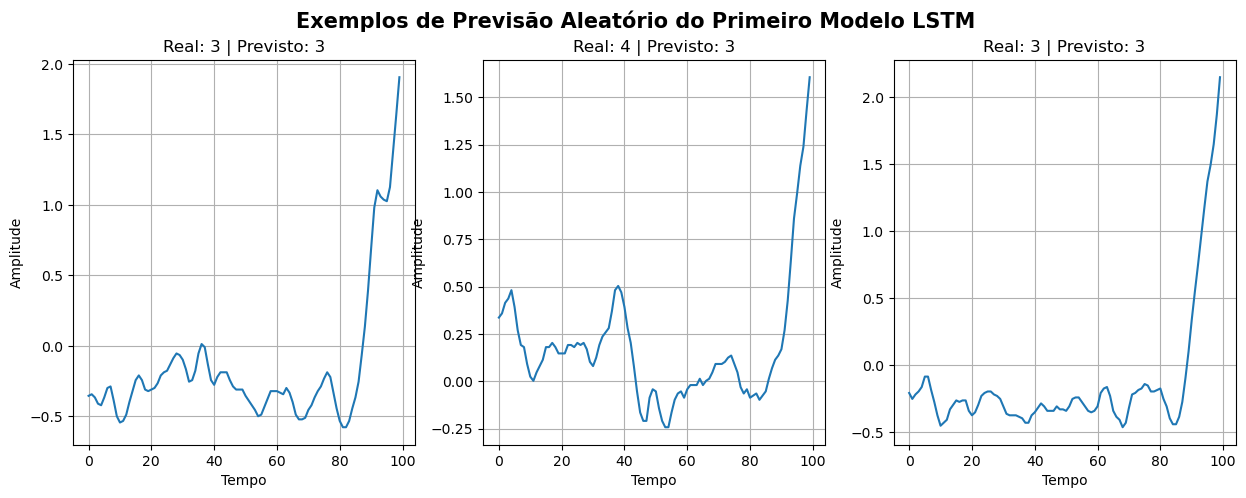

In [9]:
# Selecionar 3 amostras aleatórias do conjunto de teste
indices_amostras = np.random.choice(len(X_teste), 3, replace=False)
X_exemplos = X_teste[indices_amostras]
y_exemplos = y_teste[indices_amostras]

# Fazer previsões com o modelo treinado
previsoes_1 = primeiro_lstm.predict(X_exemplos)
y_preditos = np.argmax(previsoes_1, axis=1)
y_reais = np.argmax(y_exemplos, axis=1)

# Plotar os exemplos com previsões vs. rótulos reais
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(X_exemplos[i])  # Plot do sinal ECG
    plt.title(f"Real: {y_reais[i]} | Previsto: {y_preditos[i]}")
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")
    plt.grid()

plt.suptitle("Exemplos de Previsão Aleatório do Primeiro Modelo LSTM", fontsize=15, fontweight='bold')

Apesar da configuração relativamente simples, o primeiro modelo LSTM apresentou um desempenho satisfatório na classificação dos sinais de ECG. Com apenas três camadas LSTM e um total de 112 neurônios, o modelo conseguiu aprender padrões temporais relevantes e distinguir diferentes classes de arritmias de forma eficaz.

A utilização da ativação tanh nas camadas LSTM, aliada à regularização via Dropout, contribuiu para um treinamento estável e uma boa generalização. A acurácia obtida nos dados demonstra que, mesmo com uma arquitetura enxuta, o modelo foi capaz de capturar informações essenciais do sinal e realizar previsões coerentes com os rótulos verdadeiros.

### Segundo Modelo

O segundo modelo LSTM foi configurado para processar sequências de sinais de ECG com 100 timesteps, ampliando a capacidade de aprendizado e generalização. Em vez de três camadas, essa arquitetura possui o dobro de camadas e neurônios, sendo composta por seis camadas LSTM com 128, 64, 32, 16, 8 e 4 neurônios, respectivamente, todas utilizando a ativação tanh. Para evitar overfitting e melhorar a generalização, cada camada LSTM é seguida por uma camada Dropout com taxa de 40% (o dobro dos 20% do primeiro modelo). A última camada é uma camada Dense com ativação softmax, responsável por classificar os sinais em suas respectivas categorias. O modelo será treinado por 40 épocas utilizando o otimizador Adam e a função de perda categorical_crossentropy.

In [10]:
# Criar a instância do segundo modelo LSTM com 6 camadas com 128, 64, 32, 16, 8 e 4 neurônios, dropout de 40%
modelo_lstm_duplo = Modelo_LSTM(formato_entrada=formato_entrada, num_classes=num_classes, unidades_lstm=[128, 64, 32, 16, 8, 4], dropout=0.4)

# Construir o modelo 
segundo_lstm = modelo_lstm_duplo.construir_modelo()

/home/gui/miniconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Visualização do segundo modelo

(-0.5, 1449.5, 4255.5, -0.5)

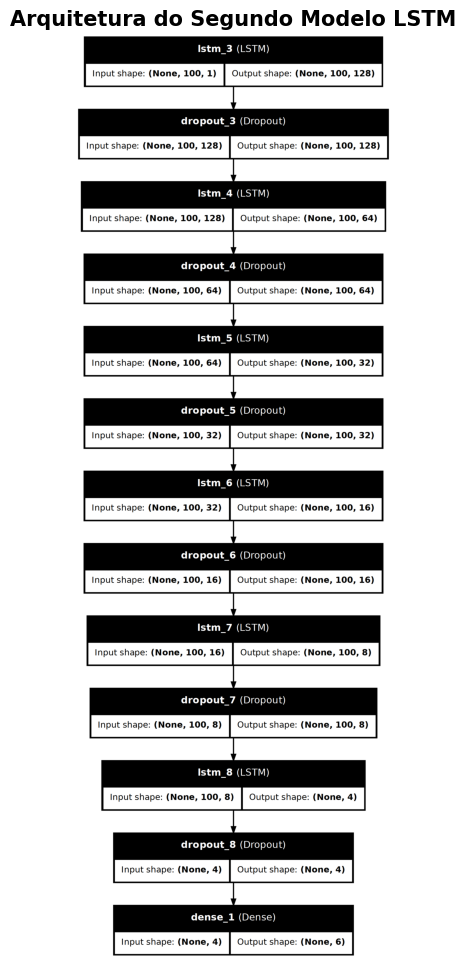

In [11]:
# Gera o diagrams do modelo
plot_model(segundo_lstm, to_file="./imgs/segundo_lstm.png", show_shapes=True, show_layer_names=True)

img_segundo_lstm = plt.imread("./imgs/segundo_lstm.png")

# Plotar a arquitetura do modelo
plt.figure(figsize=(15, 12))
plt.imshow(img_segundo_lstm)
plt.title("Arquitetura do Segundo Modelo LSTM", fontsize=15, fontweight='bold')
plt.axis("off")

### Treinamento do segundo modelo

In [12]:
# Treinar o primeiro modelo
segundo_historico = segundo_lstm.fit(X_treino, y_treino, 
                              epochs=40, batch_size=32, 
                              validation_data=(X_teste, y_teste))

Epoch 1/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4591 - loss: 1.5426 - val_accuracy: 0.6279 - val_loss: 1.1327
Epoch 2/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5635 - loss: 1.1981 - val_accuracy: 0.6279 - val_loss: 1.0033
Epoch 3/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6066 - loss: 1.1342 - val_accuracy: 0.6279 - val_loss: 0.9409
Epoch 4/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6377 - loss: 1.0180 - val_accuracy: 0.6279 - val_loss: 0.9122
Epoch 5/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6196 - loss: 0.9987 - val_accuracy: 0.6279 - val_loss: 0.8995
Epoch 6/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6439 - loss: 0.9619 - val_accuracy: 0.6279 - val_loss: 0.8943
Epoch 7/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6204 - loss: 0.9674 - val_accuracy: 0.6279 - val_loss: 0.8922
Epoch 8/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6429 - loss: 0.9550 - val_accuracy: 0.6279 - v

### Acurácia no conjunto de teste do segundo modelo

In [13]:
# Avaliar no conjunto de teste
perda, acuracia = segundo_lstm.evaluate(X_teste, y_teste)
print(f"\n Acurácia no conjunto de teste: {acuracia * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8707 - loss: 0.5449

 Acurácia no conjunto de teste: 86.94%


### Histórico de perda durante o treinamento do segundo modelo

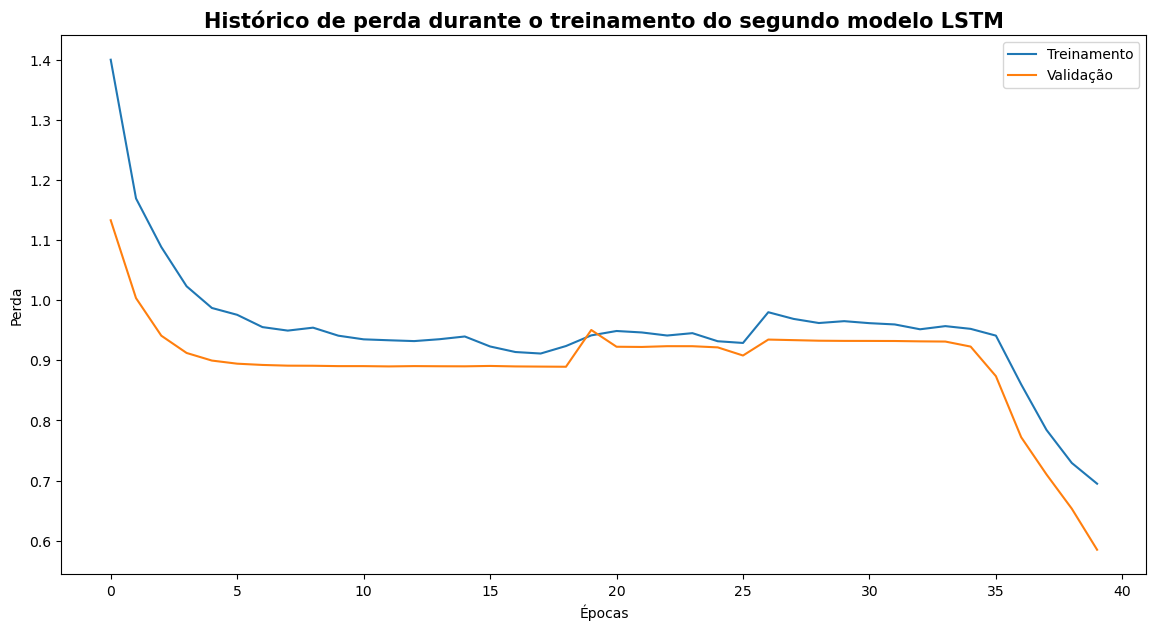

In [14]:
# Plotando o histórico de perda
plt.figure(figsize=(14,7))
plt.plot(segundo_historico.history['loss'], label='Treinamento')
plt.plot(segundo_historico.history['val_loss'], label='Validação')
plt.title('Histórico de perda durante o treinamento do segundo modelo LSTM', fontsize=15, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

### Exemplos aleatórios de previsão x rótulo do segundo modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Text(0.5, 0.98, 'Exemplos de Previsão Aleatório do Segundo Modelo LSTM')

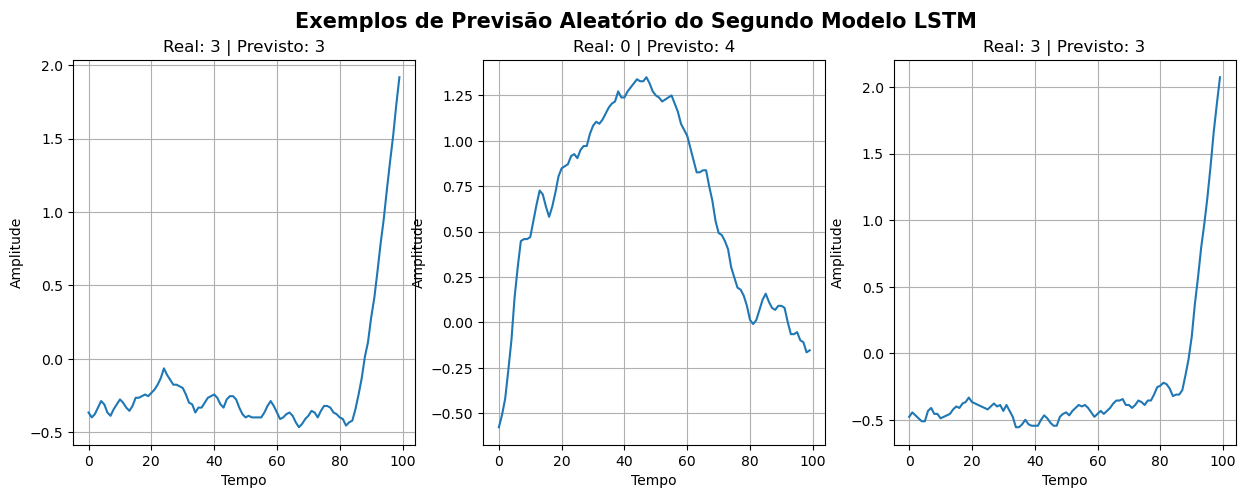

In [15]:
# Selecionar 3 amostras aleatórias do conjunto de teste
indices_amostras = np.random.choice(len(X_teste), 3, replace=False)
X_exemplos = X_teste[indices_amostras]
y_exemplos = y_teste[indices_amostras]

# Fazer previsões com o modelo treinado
previsoes_2 = segundo_lstm.predict(X_exemplos)
y_preditos = np.argmax(previsoes_2, axis=1)
y_reais = np.argmax(y_exemplos, axis=1)

# Plotar os exemplos com previsões vs. rótulos reais
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(X_exemplos[i])  # Plot do sinal ECG
    plt.title(f"Real: {y_reais[i]} | Previsto: {y_preditos[i]}")
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")
    plt.grid()

plt.suptitle("Exemplos de Previsão Aleatório do Segundo Modelo LSTM", fontsize=15, fontweight='bold')

Apesar do aumento na complexidade, o segundo modelo LSTM, com seis camadas e um maior número total de neurônios, apresentou desempenho inferior na classificação dos sinais de ECG. Embora a arquitetura tenha sido projetada para capturar padrões temporais mais sutis, o aumento do dropout e da profundidade da rede pode ter dificultado a generalização, resultando em treinamento instável e menor acurácia. Esses resultados sugerem que, para esse problema específico, uma configuração mais simples pode ser mais eficaz na extração de informações essenciais do sinal.